In [1]:
#!pip install numpy
#!pip install ipympl

%matplotlib ipympl
import scipy
import numpy as np
import matplotlib.pyplot as plt
import csv


# Utilisation d'un chemin brut pour éviter les erreurs de séquence d'échappement
file_path = r'E:\OPTIMISATION\Project\data.csv'  # Remarque sur le chemin brut

# Arrays to hold the data
temps = []
position = []

# Vérification si le fichier existe
import os
if os.path.exists(file_path):
    # Reading the data
    with open(file_path, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')  # Assurez-vous que le fichier utilise des tabulations comme séparateurs
        for row in reader:
            temps.append(float(row[0]))  # Conversion en float
            position.append(float(row[1]))  # Conversion en float

    # Affichage des données
    print("Time:", temps)
    print("Position:", position)
else:
    print(f"Le fichier n'existe pas à cet emplacement: {file_path}")

print("Time:", temps)
print("Position:", position)

Le fichier n'existe pas à cet emplacement: E:\OPTIMISATION\Project\data.csv
Time: []
Position: []


In [2]:


import numpy as np

# Constantes
M = 70000  # kg
g = 9.81  # m/s²
A0, A1 = 780, 6.4  # N, N/tonne
B0, B1 = 0, 0.14  # N, N/tonne/(km/h)
C0, C1 = 0.3634, 0  # N/(km/h)²
eta_motor = 0.8  # Rendement moteur
eta_battery = 0.9  # Rendement batterie
P_aux = 35000  # W

# Paramètres réseau
V_sst = 790  # V
R_sst = 33e-3  # Ohms
rho_LAC = 95e-6  # Ohms/m
rho_rail = 10e-6  # Ohms/m

# Données de position-temps
t = np.array(temps)  # secondes
position = np.array(position)  # mètres

# Calcul des grandeurs mécaniques
v = np.gradient(position, t)  # m/s
a = np.gradient(v, t)  # m/s²
alpha = 0  # radians

# Résistance à l'avancement
F_resistive = (A0 + A1 * (M / 1000)) + (B0 + B1 * (M / 1000) * v * 3.6) + (C0 + C1 * (M / 1000) * (v * 3.6)**2)

# Force motrice
F_motrice = M * a + M * g * np.sin(alpha) + F_resistive


# Puissance mécanique
P_mec = F_motrice * v  # En watts

# Puissance totale demandée

#P_train = P_mec / eta_motor + P_aux  # En watts

P_train = [
    (P / eta_motor + P_aux) if P >= 0 else (P * eta_motor + P_aux)
    for P in P_mec
]


IndexError: index 0 is out of bounds for axis 0 with size 0

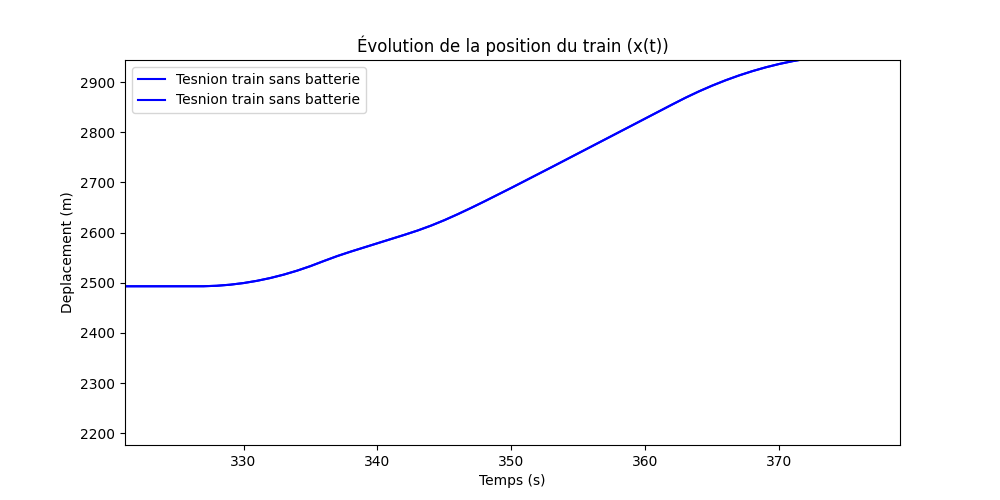

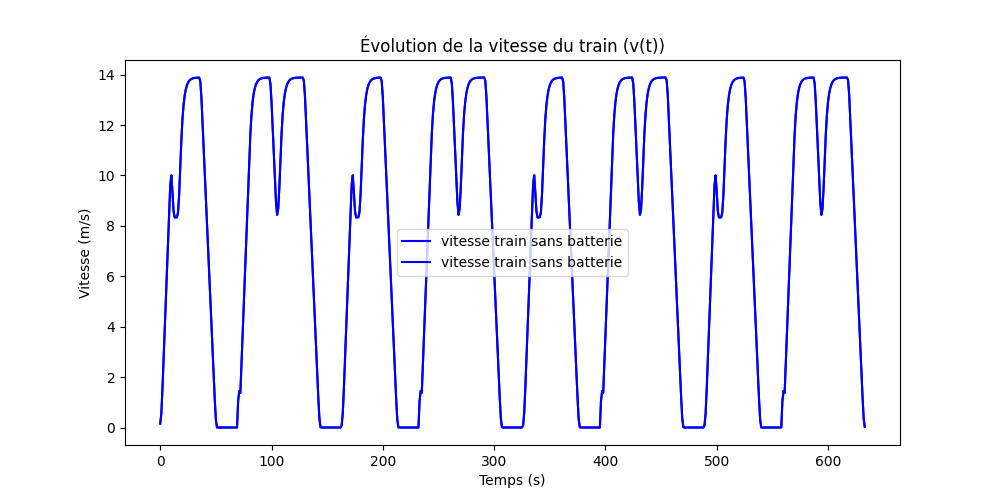

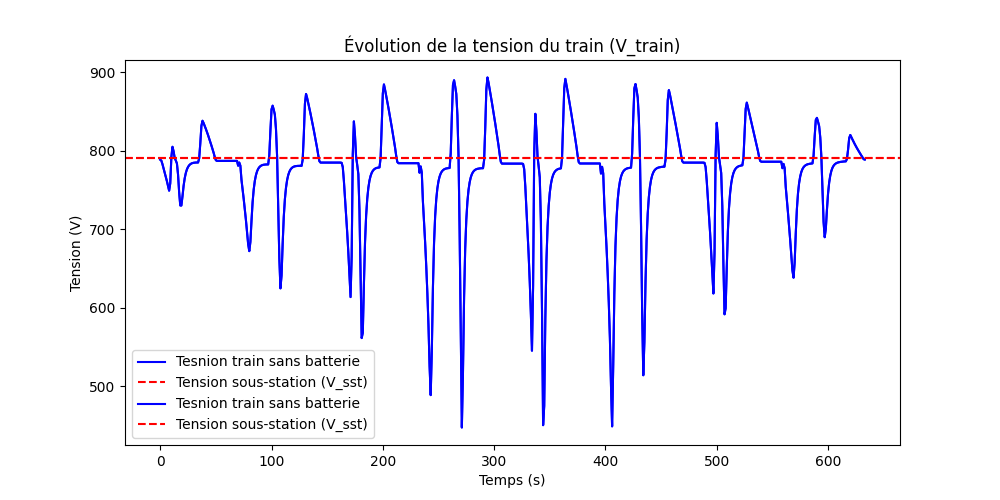

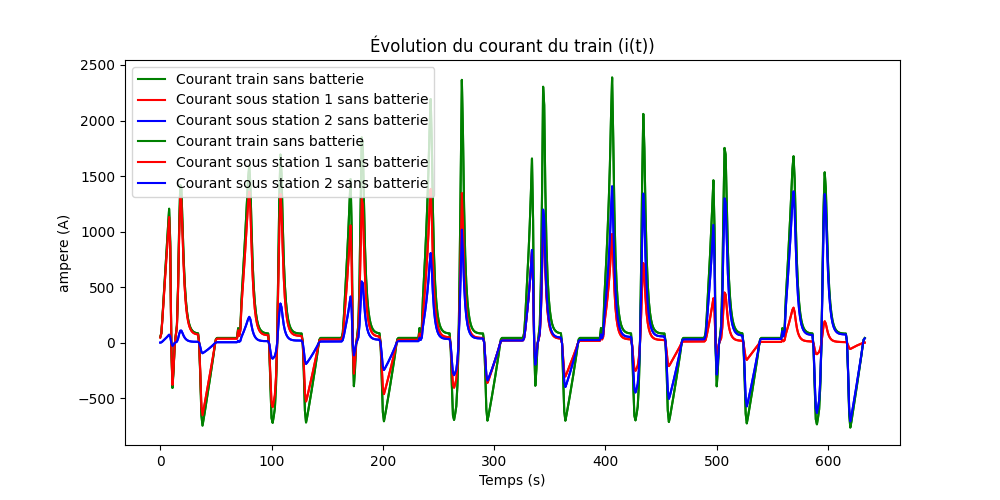

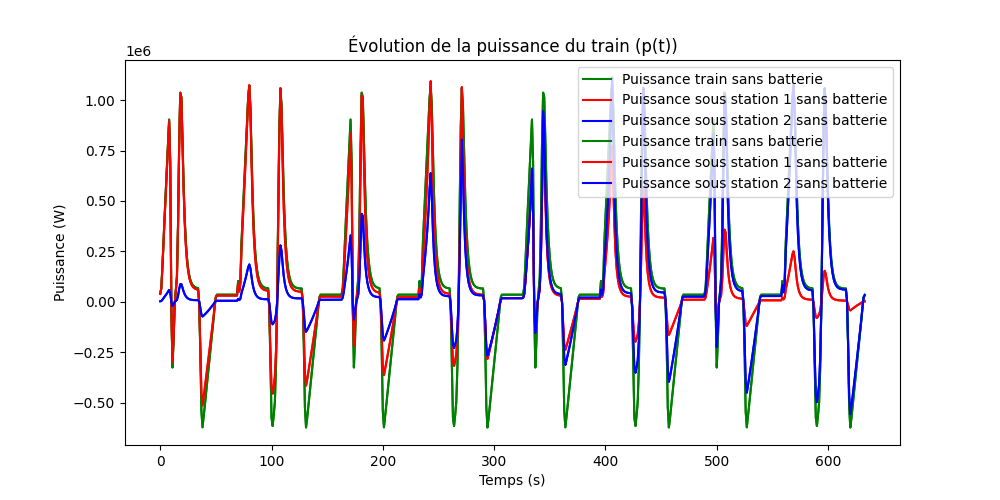

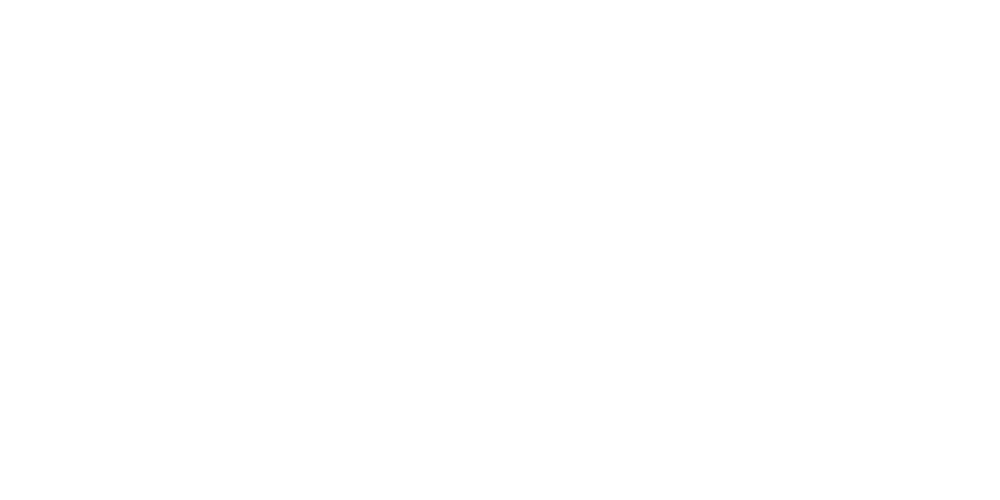

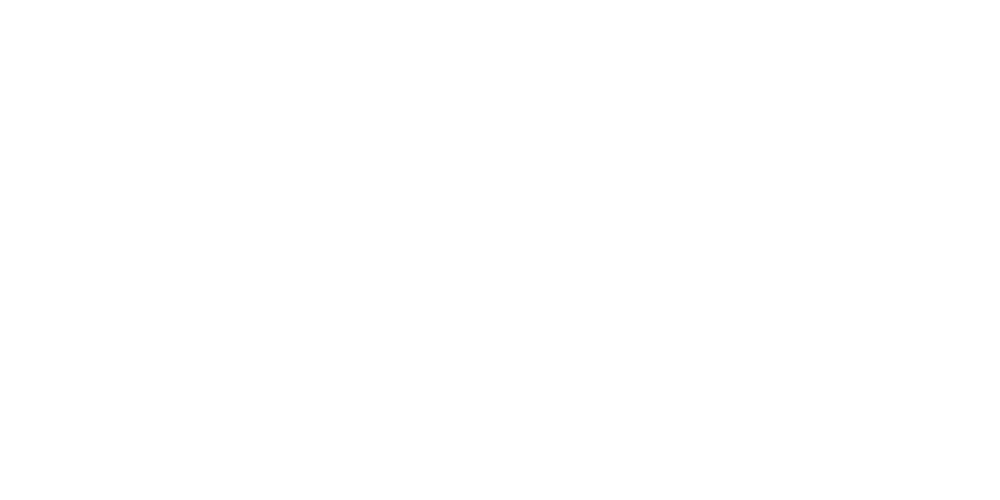

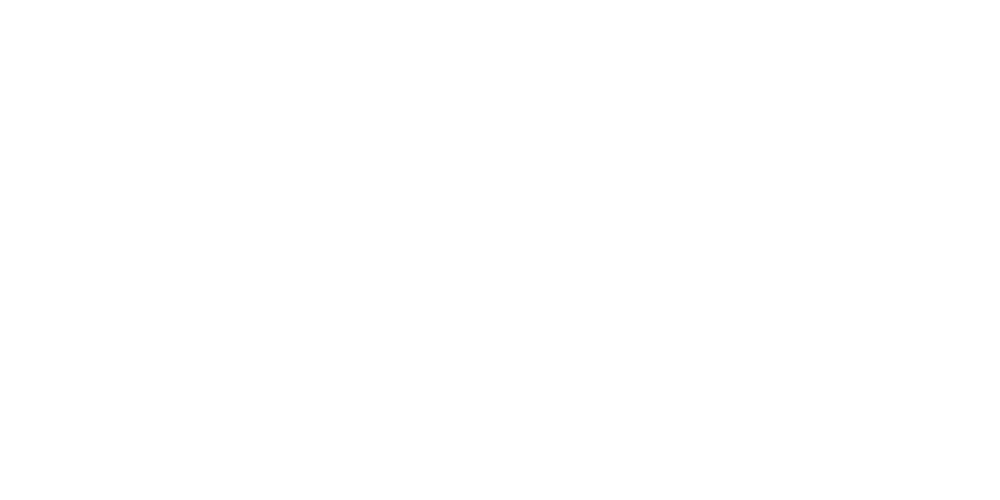

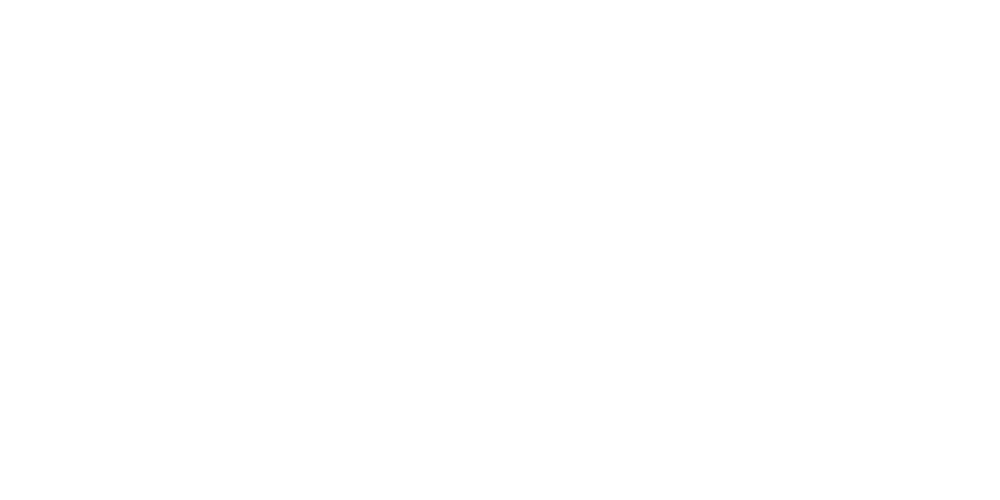

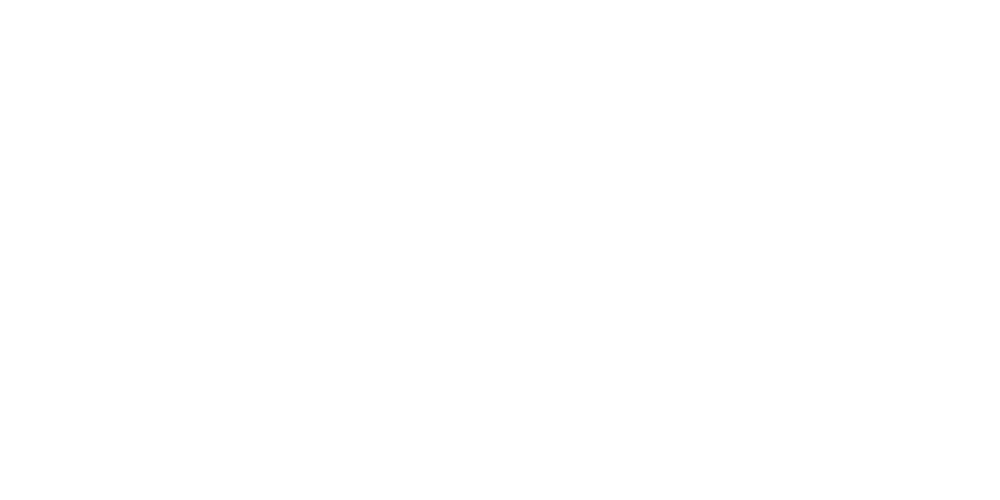

In [24]:
# --- Simulation sans batterie ---
V_train_no_batt = []
I_train = []
I_1 = []
I_2 = []
Psst_1 = []
Psst_2 = []

for i in range(len(temps)):
    # Résistances des segments de LAC et rail
    R_LAC1 = rho_LAC * position[i]  # Jusqu'au train
    R_LAC2 = rho_LAC * (5000 - position[i])  # Après le train
    R_rail1 = rho_rail * position[i]
    R_rail2 = rho_rail * (5000 - position[i])
    R_eq1=(R_sst + R_LAC1 + R_rail1)
    R_eq2=(R_sst + R_LAC2 + R_rail2)
    # Résistance équivalente (Req)
    R_eq = 1 / (1 / R_eq1 + 1 / R_eq2)
    # Calcul de la tension V_train à partir de l'équation quadratique

    delta = V_sst**2 - 4 * R_eq * P_train[i]
    if delta >= 0:
        V_train = 0.5 * (V_sst + np.sqrt(delta))
    else:
        V_train = np.NaN  # Cas où la tension est impossible

    V_train_no_batt.append(V_train)

    I_train.append((V_sst-V_train)/R_eq)
    I_1.append((V_sst-V_train)/R_eq*(R_eq2/(R_eq2+R_eq1)))
    I_2.append((V_sst-V_train)/R_eq*(R_eq1/(R_eq2+R_eq1)))

I_train=np.array(I_train)
I_1=np.array(I_1)
I_2=np.array(I_2)
# calcule des autres grandeurs:

Psst_1 = I_1 * V_sst
Psst_2 = I_2 * V_sst

# --- Tracé des résultats ---



# position
plt.figure(figsize=(10, 5))
plt.figure(1)
plt.plot(t, position, label="Tesnion train sans batterie", color="blue")
plt.xlabel("Temps (s)")
plt.ylabel("Deplacement (m)")
plt.title("Évolution de la position du train (x(t))")
plt.legend()
plt.grid()
plt.show()

# Vitesse
plt.figure(figsize=(10, 5))
plt.figure(2)
plt.plot(t, v, label="vitesse train sans batterie", color="blue")
plt.xlabel("Temps (s)")
plt.ylabel("Vitesse (m/s)")
plt.title("Évolution de la vitesse du train (v(t))")
plt.legend()
plt.grid()
plt.show()
# Tensions
plt.figure(figsize=(10, 5))
plt.figure(3)
plt.plot(t, V_train_no_batt, label="Tesnion train sans batterie", color="blue")
plt.axhline(V_sst, color="red", linestyle="--", label="Tension sous-station (V_sst)")
plt.xlabel("Temps (s)")
plt.ylabel("Tension (V)")
plt.title("Évolution de la tension du train (V_train)")
plt.legend()
plt.grid()
plt.show()

# courants
plt.figure(figsize=(10, 5))
plt.figure(4)
plt.plot(t, I_train, label="Courant train sans batterie", color="green")
plt.plot(t, I_1, label="Courant sous station 1 sans batterie", color="red")
plt.plot(t, I_2, label="Courant sous station 2 sans batterie", color="blue")
plt.xlabel("Temps (s)")
plt.ylabel("ampere (A)")
plt.title("Évolution du courant du train (i(t))")
plt.legend()
plt.grid()
plt.show()

# puissances
plt.figure(figsize=(10, 5))
plt.figure(5)
plt.plot(t, P_train, label="Puissance train sans batterie", color="green")
plt.plot(t, Psst_1, label="Puissance sous station 1 sans batterie", color="red")
plt.plot(t, Psst_2, label="Puissance sous station 2 sans batterie", color="blue")
plt.xlabel("Temps (s)")
plt.ylabel("Puissance (W)")
plt.title("Évolution de la puissance du train (p(t))")
plt.legend()
plt.grid()
plt.show()


In [17]:
# --- Simulation avec batterie ---
# Batterie
def batterie_simulation(C_batt, P_batt_max, P_seuil, position, temps):
    """
    Simule le fonctionnement du train avec une batterie en utilisant des variables globales pour le contexte.

    Paramètres:
        C_batt (float): Capacité de la batterie en joules.
        P_batt_max (float): Puissance maximale de charge/décharge de la batterie (W).
        Seuil (float): Seuil de puissance apartir du quel on commence a consommé l'energie depuis la batterie
        K(float): relation entre le cout et la capacité de la batterie
        position (list): Liste des positions du train (m).
        temps (list): Liste des instants de temps (s).


    Retourne:
        V_train_with_batt (list): Tension du train avec la batterie (V).
        E_batt_history (list): Historique de l'énergie de la batterie (J).
        Cout_batt (float): cout de la batterie
        Delta_Vmax (float): la plus grande shute de tension

    """

    E_batt_max = C_batt  # Énergie initiale de la batterie (joules)
    P_batt = [0]
    V_train_with_batt = [790]
    E_batt_history = [E_batt_max]
    P_LAC = []  # Initialisation de P_LAC comme une liste vide
    P_rheostat = []  # Initialisation de P_rheostat comme une liste vide
    I_train=[]
    I_1=[]
    I_2=[]
    for i in range(1, len(temps)):
        delta_t = temps[i] - temps[i-1]  # Le pas de temps (1s ici, mais il peut être ajusté)
        # Résistances des segments de LAC et rail
        R_LAC1 = rho_LAC * position[i]  # Jusqu'au train
        R_LAC2 = rho_LAC * (5000 - position[i])  # Après le train
        R_rail1 = rho_rail * position[i]
        R_rail2 = rho_rail * (5000 - position[i])

        if P_train[i] <= 0:  # Le train freine
            if E_batt_history[-1] < E_batt_max:  # Batterie pas pleine
                P_batt.append(max(P_train[i], -P_batt_max))  # Recharge dans la limite de P_batt_max the absolute value !! # j'en doute !!
                E_batt_history.append(min(E_batt_max, E_batt_history[-1] - P_batt[-1] * delta_t))  # Mise à jour de l'énergie de la batterie
                P_rheostat.append(P_batt[-1] - P_train[i]) # Le reste va au rhéostat because we have p train <0

            else:  # Batterie pleine
                P_batt.append(0)
                P_rheostat.append(-P_train[i])  # Toute l'énergie va au rhéostat
                E_batt_history.append(E_batt_history[-1])
            P_LAC.append(0)  # Pas de demande à la LAC pendant le freinage

        elif P_train[i]>P_seuil:  # Le train accélère
            if E_batt_history[-1] > 0:  # Batterie pas vide
                P_batt.append(P_train[i] -  P_seuil)  # Limite la puissance fournie par la batterie j'en doute
                E_batt_history.append(max(0, E_batt_history[-1] - P_batt[-1] * delta_t))  # Mise à jour de l'énergie de la batterie
                P_LAC.append(P_seuil)  # Complément demandé à la LAC

            else:  # Batterie vide
                P_batt.append(0)
                E_batt_history.append(E_batt_history[-1])  # Pas d'énergie supplémentaire, la batterie reste à zéro
                P_LAC.append(P_train[i])  # Toute l'énergie vient de la LAC
        else :
            P_batt.append(0)
            E_batt_history.append(E_batt_history[-1])  # Pas d'énergie supplémentaire, la batterie reste à zéro
            P_LAC.append(P_train[i])  # Toute l'énergie vient de la LAC


        # Calcul de la tension V_train
        R_eq = 1 / (1 / (R_sst + R_LAC1 + R_rail1) + 1 / (R_sst + R_LAC2 + R_rail2))  # Calcul de R_eq
        delta = V_sst**2 - 4 * R_eq * P_LAC[-1]  # Calcul du discriminant pour la tension

        if delta > 0:
            V_train = 0.5 * (V_sst + np.sqrt(delta))  # Calcul de la tension
        else:
            V_train = np.nan  # Cas où la tension est impossible
            print (1)


        V_train_with_batt.append(V_train)  # Stocke la tension à chaque instant
        I_train.append((V_sst-V_train)/R_eq)
        I_1.append((V_sst-V_train)/R_eq*(R_eq2/(R_eq2+R_eq1)))
        I_2.append((V_sst-V_train)/R_eq*(R_eq1/(R_eq2+R_eq1)))
        I_train.append((V_sst-V_train)/R_eq)



        # Correction de l'ajout final
    if len(V_train_with_batt) < len(t):
        V_train_with_batt.append(V_train_with_batt[-1])  # Ajout de la dernière valeur de la tension


    Delta_Vmax=V_sst-np.min(V_train_with_batt)
    cout_batt=C_batt # le coût est proportionnelle à la capacité de batterie


    return V_train_with_batt, E_batt_history, Delta_Vmax, cout_batt


def plot_simulation_results():

    # --- Tracé des résultats ---
    print("Longueur de t:", len(t))
    print("Longueur de V_train_no_batt:", len(V_train_no_batt))
    print("Longueur de V_train_with_batt:", len(V_train_with_batt))
    print("Longueur E_batt_history :", len(E_batt_history))

    assert len(t) == len(V_train_no_batt), f"Erreur : longueur de t ({len(t)}) et de V_train_no_batt ({len(V_train_no_batt)}) ne sont pas égales."
    assert len(t) == len(V_train_with_batt), f"Erreur : longueur de t ({len(t)}) et de V_train_with_batt ({len(V_train_with_batt)}) ne sont pas égales."
    # Tensions
    plt.figure(7)
    plt.figure(figsize=(14, 8))
    #plt.plot(t, V_train_no_batt, label="Sans batterie", color="blue")
    plt.plot(t, V_train_with_batt, label="Avec batterie", color="green")
    plt.axhline(V_sst, color="red", linestyle="--", label="Tension sous-station (V_sst)")
    plt.xlabel("Temps (s)")
    plt.ylabel("Tension (V)")
    plt.title("Évolution de la tension du train (V_train)")
    plt.legend()
    plt.grid()
    plt.show()

    # puissances

    plt.figure(8)
    plt.figure(figsize=(14, 8))
    plt.plot(t, P_train, label="Puissance train sans batterie", color="green")
    plt.xlabel("Temps (s)")
    plt.ylabel("Puissance (W)")
    plt.title("Évolution de la puissance du train (p(t))")
    plt.legend()
    plt.grid()
    plt.show()

    # Énergie de la batterie
    plt.figure(6)
    plt.figure(figsize=(14, 8))
    plt.plot(t, np.array(E_batt_history) / 1e6, label="Énergie de la batterie (MJ)", color="orange")
    plt.xlabel("Temps (s)")
    plt.ylabel("Énergie (MJ)")
    plt.title("Évolution de l'énergie de la batterie")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    # courant
    plt.figure(figsize=(14, 8))
    plt.figure(7)
    plt.plot(t, I_train, label="Courant train sans batterie", color="green")
    plt.plot(t, I_1, label="Courant sous station 1 sans batterie", color="red")
    plt.plot(t, I_2, label="Courant sous station 2 sans batterie", color="blue")
    plt.xlabel("Temps (s)")
    plt.ylabel("ampere (A)")
    plt.title("Évolution du courant du train (i(t))")
    plt.legend()
    plt.grid()
    plt.show()


Longueur de t: 634
Longueur de V_train_no_batt: 634
Longueur de V_train_with_batt: 634
Longueur E_batt_history : 634


C:\Users\zined\AppData\Local\Temp\ipykernel_7136\1913745450.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(14, 8))


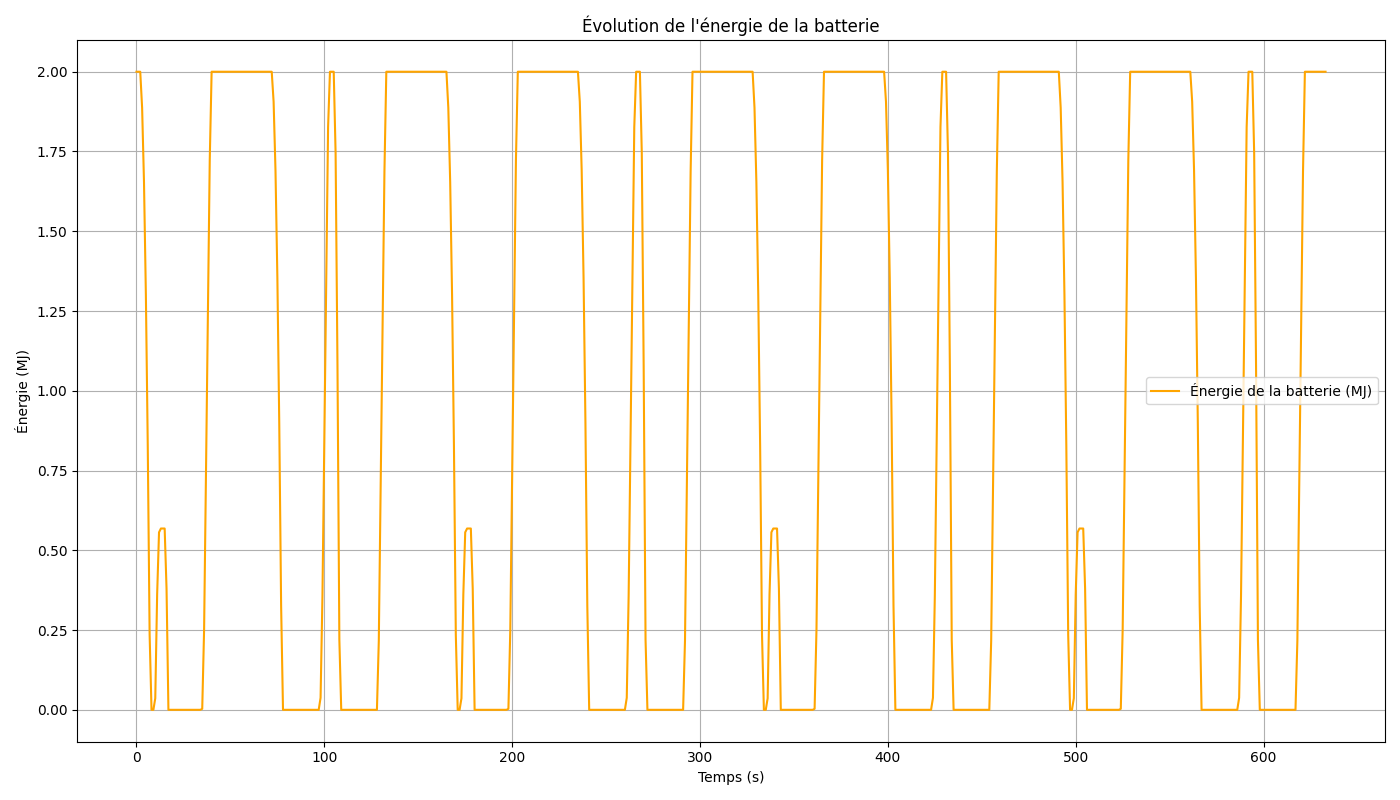

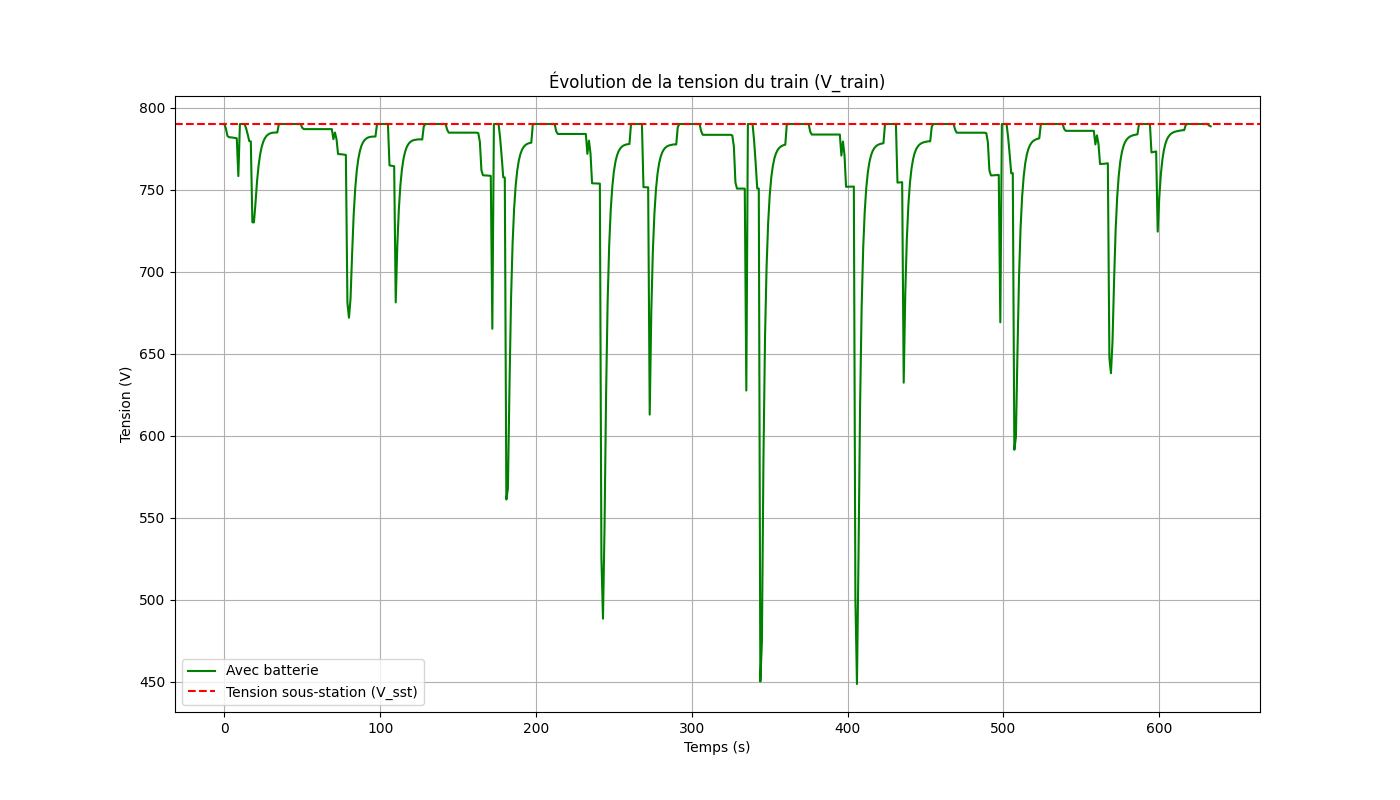

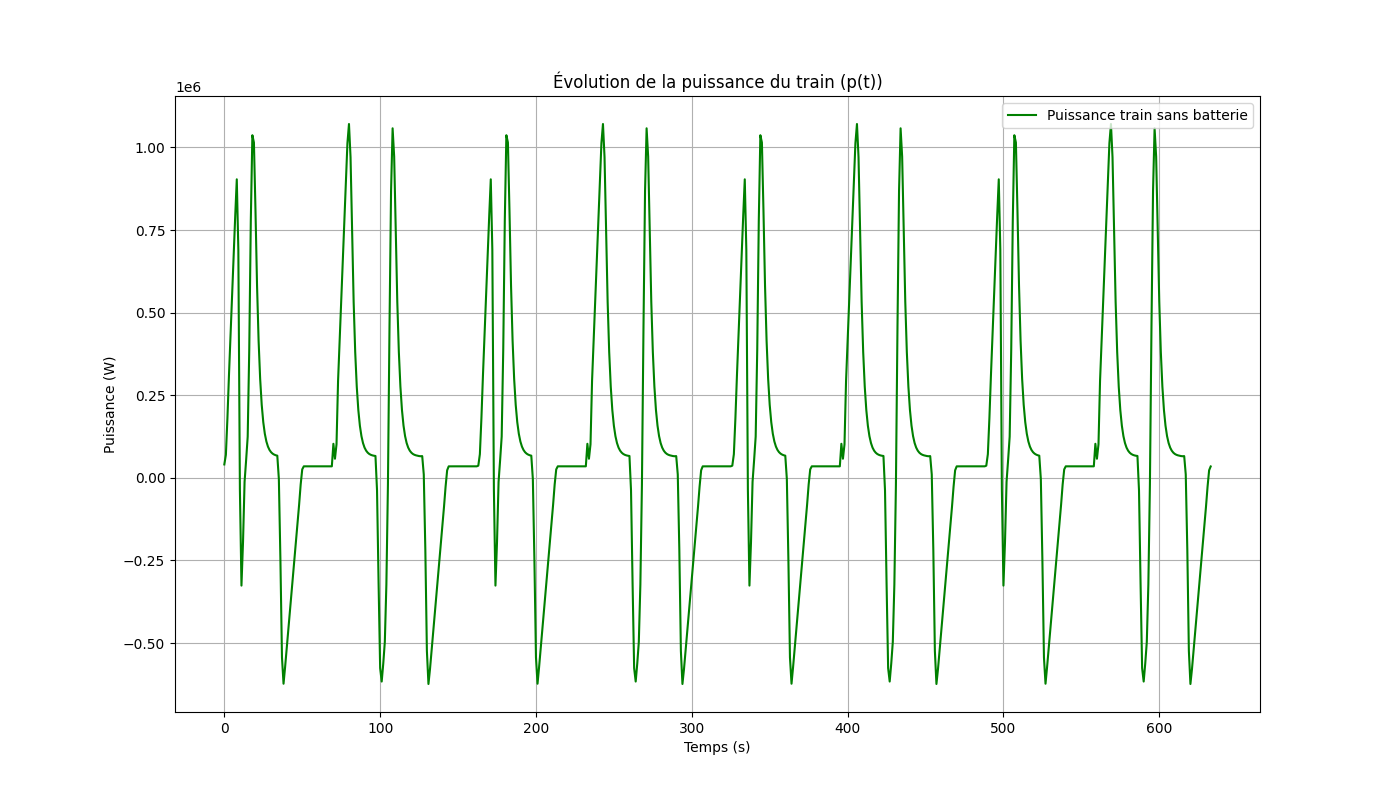

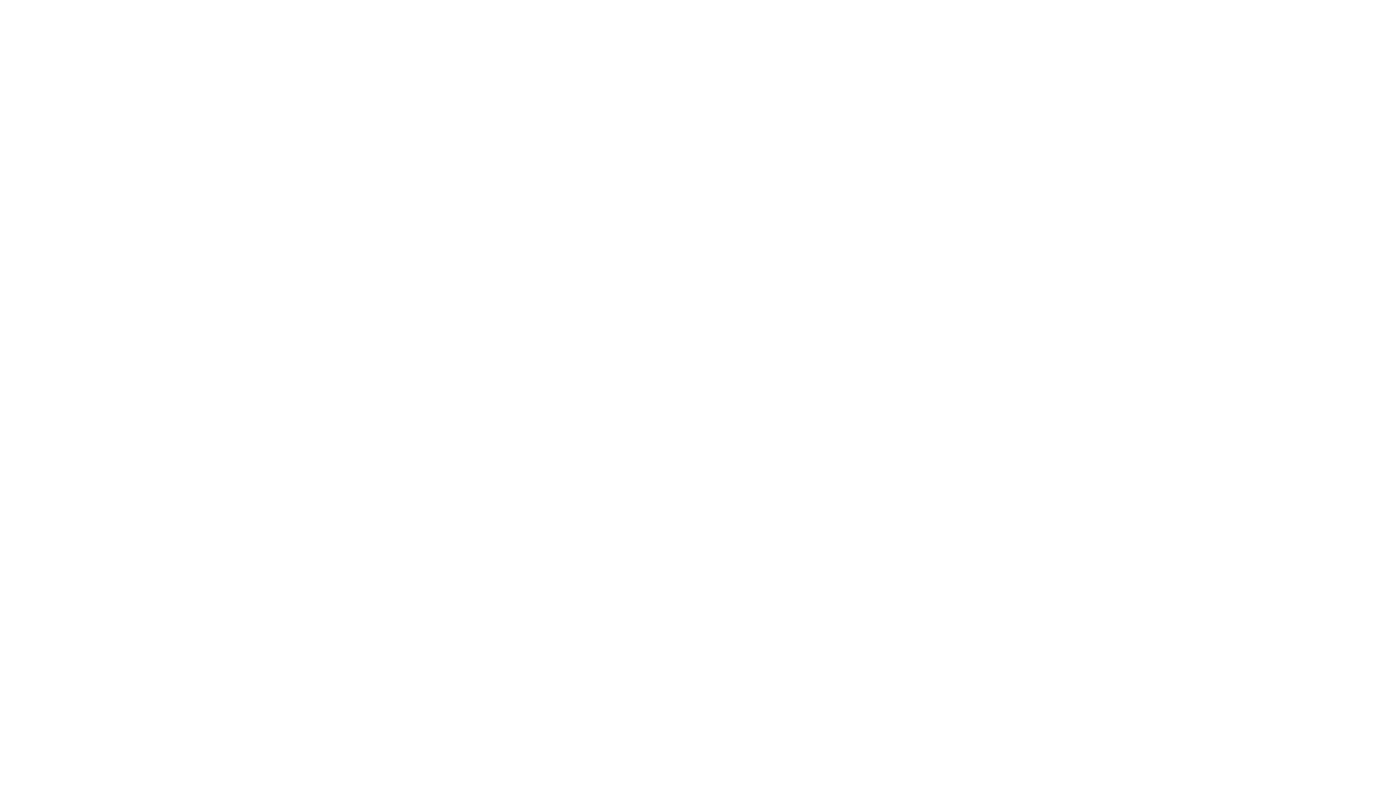

In [20]:
[V_train_with_batt, E_batt_history, Delta_Vmax ,cout_batt]= batterie_simulation(2e6, 490e3, 2e5, position, temps)
plot_simulation_results()

# Algorithme génétique 

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Paramètres de l'algorithme génétique
population_size = 50  # Taille de la population
generations = 50      # Nombre de générations
mutation_rate = 0.1   # Taux de mutation
tournament_size = 3   # Taille du tournoi pour la sélection
alpha_range = (-0.1, 1.1)  # Plage de l'aléa pour le croisement

# Plages de recherche pour les variables de décision
capacite_batterie_range = np.linspace(0, 14, 200)  # Plage de capacité de la batterie (en kWh)
seuil_puissance_range = np.linspace(0, 1, 200)  # Plage du seuil de puissance (en kW)

# Fonction de simulation pour chaque individu (couple capacité et seuil)
def simulation(capacite_batterie, seuil_puissance):
    _, _, Delta_Vmax, cout_batt = batterie_simulation(capacite_batterie * 3600000,
                                                      P_batt_max=4.5e5,
                                                      P_seuil=seuil_puissance * 10**6,
                                                      position=position, temps=temps)
    return Delta_Vmax, cout_batt*1e-3 / 3600  # Conversion du coût en kWh

# Initialisation de la population
def init_population(pop_size):
    population = []
    for _ in range(pop_size):
        capacite_batterie = random.choice(capacite_batterie_range)
        seuil_puissance = random.choice(seuil_puissance_range)
        population.append([capacite_batterie, seuil_puissance])
    return population

# Calcul des objectifs (chute de tension et coût) pour chaque individu
def evaluate_population(population):
    return [simulation(individu[0], individu[1]) for individu in population]

# Fonction de tri par dominance (calcul des rangs NSGA-II)
def non_dominated_sorting(population, objectives):
    domination_count = [0] * len(population)
    dominated_solutions = [[] for _ in range(len(population))]
    fronts = [[]]

    for i in range(len(population)):
        for j in range(len(population)):
            if i != j:
                if objectives[i][0] < objectives[j][0] and objectives[i][1] < objectives[j][1]:
                    dominated_solutions[i].append(j)
                elif objectives[j][0] < objectives[i][0] and objectives[j][1] < objectives[i][1]:
                    domination_count[i] += 1
                elif objectives[i][0] <= objectives[j][0] and objectives[i][1] <= objectives[j][1]:
                    domination_count[i] += 1

    for i in range(len(population)):
        if domination_count[i] == 0:
            fronts[0].append(i)

    current_front = 0
    while len(fronts[current_front]) > 0:
        next_front = []
        for i in fronts[current_front]:
            for j in dominated_solutions[i]:
                domination_count[j] -= 1
                if domination_count[j] == 0:
                    next_front.append(j)
        current_front += 1
        fronts.append(next_front)

    return fronts

# Sélection par tournoi
def tournament_selection(population, objectives, fronts, tournament_size=3):
    selected = []

    # Tri des individus par rang de dominance, les meilleurs sont ceux qui ont les rangs les plus bas
    ranked_population = []
    for i in range(len(population)):
        ranked_population.append((population[i], objectives[i], i))  # Utilisation de l'indice de l'individu

    # Trier d'abord par rang de dominance (indice de front dans `fronts`)
    ranked_population.sort(key=lambda x: x[2])  # Trier par le rang (front)

    # Conserver uniquement les meilleurs 50% des individus
    top_50_percent = ranked_population[:len(ranked_population) // 2]

    # Sélectionner les meilleurs à travers un tournoi
    for _ in range(len(top_50_percent) // 2):
        tournament = random.sample(top_50_percent, tournament_size)
        sorted_tournament = sorted(tournament, key=lambda x: x[2])
        selected.append(sorted_tournament[0][0])  # Sélectionner le meilleur individu

    return selected


# Croisement (mélange des gènes des parents)
def crossover(parent1, parent2):
    alpha = random.uniform(alpha_range[0], alpha_range[1])  # Facteur de pondération aléatoire
    capacite_batterie = alpha * parent1[0] + (1 - alpha) * parent2[0]
    seuil_puissance = alpha * parent1[1] + (1 - alpha) * parent2[1]
    return [capacite_batterie, seuil_puissance]

# Mutation
def mutation(individu):
    if random.random() < mutation_rate:  # Vérification du taux de mutation
        # Choisir aléatoirement quel gène (variable) muter
        gene_to_mutate = random.choice([0, 1])  # 0 pour la capacité de la batterie, 1 pour le seuil de puissance

        if gene_to_mutate == 0:  # Mutation sur la capacité de la batterie
            perturbation = random.uniform(-0.5, 0.5)  # Légère variation aléatoire sur la capacité
            individu[0] = max(0, min(individu[0] + perturbation, max(capacite_batterie_range)))  # Ajustement à la plage de valeurs

        elif gene_to_mutate == 1:  # Mutation sur le seuil de puissance
            perturbation = random.uniform(-0.05, 0.05)  # Légère variation aléatoire sur le seuil de puissance
            individu[1] = max(0, min(individu[1] + perturbation, max(seuil_puissance_range)))  # Ajustement à la plage de valeurs

    return individu


def genetic_algorithm():
    population = init_population(population_size)
    best_solutions = []

    for generation in range(generations):
        # Évaluation des objectifs pour chaque individu
        objectives = evaluate_population(population)

        # Tri des solutions par dominance et classement
        fronts = non_dominated_sorting(population, objectives)

        # Sélection des meilleurs 50% individus par tournoi, avec les fronts passés en argument
        selected_population = tournament_selection(population, objectives, fronts)

        # Croisement pour générer 35 enfants (35 paires)
        new_population = []
        for _ in range(35):
            parent1, parent2 = random.sample(selected_population, 2)
            child = crossover(parent1, parent2)
            new_population.append(child)

        # Mutation pour générer 15 enfants (15 mutations)
        for _ in range(15):
            child_to_mutate = random.choice(new_population)  # Mutation sur les enfants générés
            mutated_child = mutation(child_to_mutate)
            new_population.append(mutated_child)

        # Nouvelle population : 50 meilleurs parents + 50 enfants générés (croisement + mutation)
        population = selected_population + new_population  # Taille de la population toujours 100

        # Enregistrer les meilleures solutions de cette génération
        best_solutions.append([objectives[i] for i in fronts[0]])

    return best_solutions

# Lancer l'algorithme génétique
best_solutions = genetic_algorithm()

# Affichage des résultats (Front de Pareto)
final_objectives = [obj for generation in best_solutions for obj in generation]
final_objectives = np.array(final_objectives)

# Tracer le front de Pareto
plt.figure(figsize=(12, 6))
plt.scatter(final_objectives[:, 1], final_objectives[:, 0], color='orange', label="Front de Pareto")
plt.xlabel("Coût de la batterie (kWh)")
plt.ylabel("Chute de tension maximale (V)")
plt.title("Front de Pareto - Algorithme Génétique (NSGA-II)")
plt.legend()
plt.show()




TypeError: list indices must be integers or slices, not numpy.float64